Libraries Installed

In [1]:
!pip install rasterio
!pip install matplotlib

In [2]:

!pip install scikit-learn


raterio is used so we dont need to convert our files to GEOtiff. https://gis.stackexchange.com/questions/397638/opening-sentinel-2-data-with-python

In [3]:

import rasterio

from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


Image name is provided and opened

In [4]:
image_path = "D:/c++/123-ES-304/"
image_list=[
    "T41RRH_20231112T061059_B02_60m.jp2",
    "T41RRH_20231112T061059_B03_60m.jp2",
    "T41RRH_20231112T061059_B04_60m.jp2",
    "T41RRH_20231112T061059_B05_60m.jp2",
    "T41RRH_20231112T061059_B06_60m.jp2",
    "T41RRH_20231112T061059_B07_60m.jp2",
    "T41RRH_20231112T061059_B8A_60m.jp2",
    "T41RRH_20231112T061059_B09_60m.jp2",
    "T41RRH_20231112T061059_B11_60m.jp2",
    "T41RRH_20231112T061059_B12_60m.jp2"
]


In [5]:
image_stack = []
for image_filename in image_list:
    image_to_open = image_path + image_filename
    with rasterio.open(image_to_open) as src:
        img = src.read(1)  
        image_stack.append(img)

stacked_data = np.stack(image_stack, axis=2)

Visualize different bands

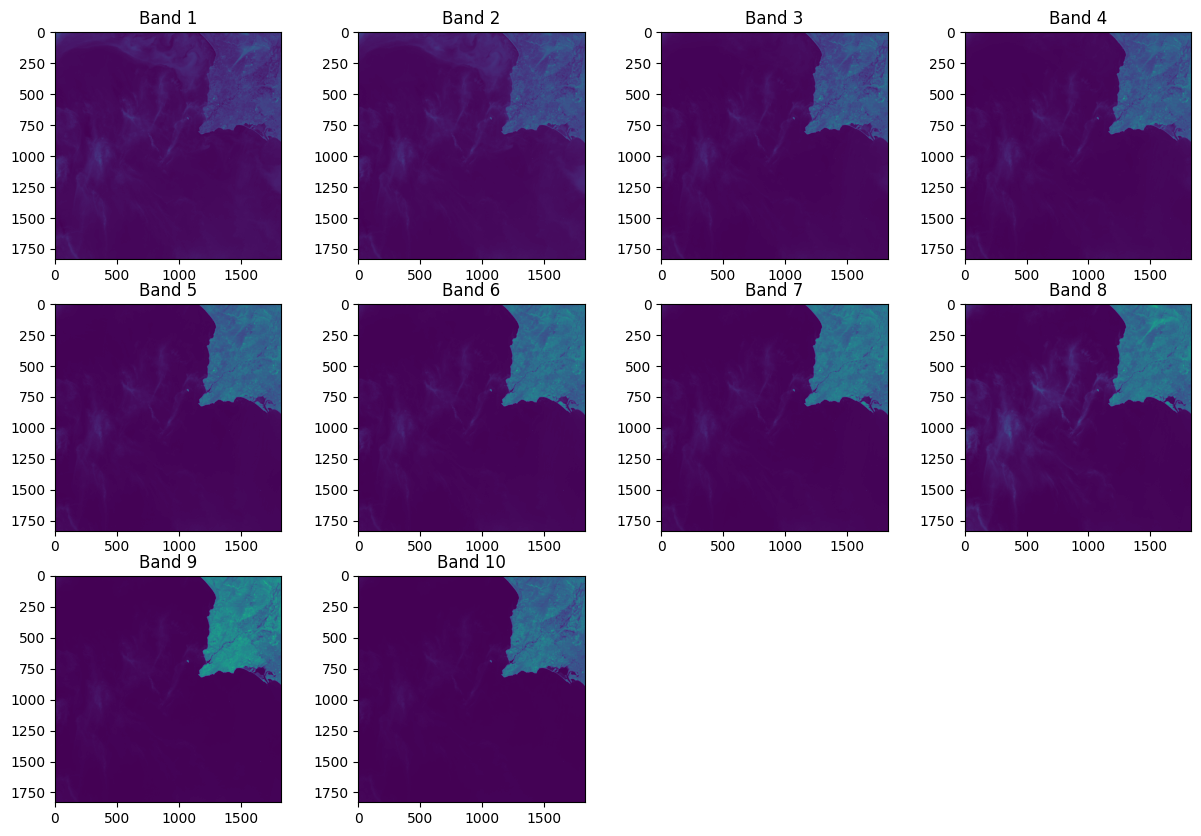

In [20]:
#show(stacked_data[:, :, 0], cmap='gray', title='First Band of Stacked Data')

num_bands = stacked_data.shape[-1]
plt.figure(figsize=(15, 10))

for i in range(num_bands):
    plt.subplot(3, 4, i + 1)
    plt.imshow(stacked_data[:, :, i])
    plt.title(f'Band {i + 1}')
    plt.axis('on')  

plt.show()

1830
1830


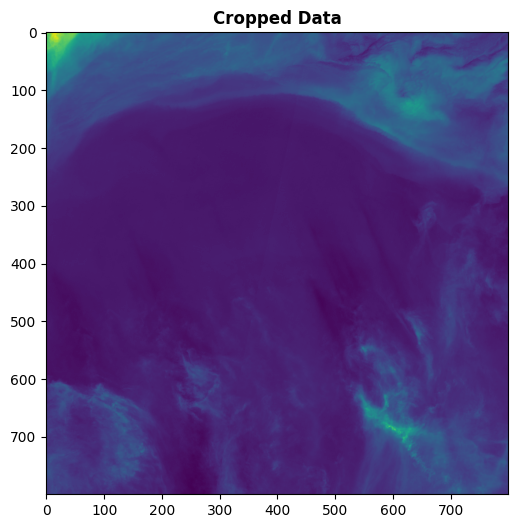

<Axes: title={'center': 'Cropped Data'}>

In [7]:
width, height = src.width, src.height
print(width)
print (height)

# Read the data for the specified window
cropped_image = stacked_data[:800, :800, :]

# Visualize the cropped image
plt.figure(figsize=(6, 6))
show(cropped_image[:, :, 0], title='Cropped Data')




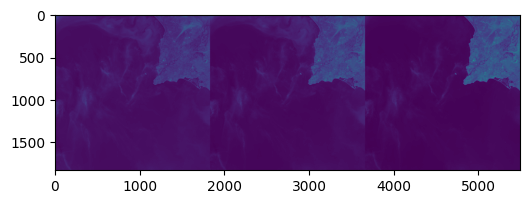

<Axes: >

In [27]:
# Concatenate bands
concatenated_image = np.concatenate((stacked_data[:, :, 0], stacked_data[:, :, 1], stacked_data[:, :, 2]), axis=1)
plt.figure(figsize=(6, 6))
show(concatenated_image)

PCA APPLYING :

In [28]:
band_means = np.mean(stacked_data, axis=(0, 1))
band_medians = np.median(stacked_data, axis=(0, 1))
band_std_devs = np.std(stacked_data, axis=(0, 1))

# Print the calculated statistics
# for i, band_file in enumerate(image_list):
#     print(f"Band {i + 1}:")
#     print(f"  Mean: {band_means[i]}")
#     print(f"  Median: {band_medians[i]}")
#     print(f"  Standard Deviation: {band_std_devs[i]}")
#     print()

In [10]:
flattened_data = stacked_data.reshape((-1, stacked_data.shape[-1]))
#This reshaping operation is often done to convert an image with multiple bands and spatial dimensions into a 2D array where each row corresponds to a pixel and each column corresponds to a band. This 2d array is needed for the PCA

In [11]:
mean_values = np.mean(flattened_data, axis=0)

# Center the data by subtracting the mean
centered_data = flattened_data - mean_values

https://www.youtube.com/watch?v=xS0zsQGiUjc

In [12]:
covariance_matrix = np.cov(centered_data, rowvar=False)
#np.cov finds out the covariance of the 2d array 
# each column represents a variable


In [13]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)


In [14]:
# Sort eigenvectors by eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]#descending
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [15]:
sorted_eigenvectors.size

100

In [34]:
# Choose the top k eigenvectors 
k = 10
selected_eigenvectors = sorted_eigenvectors[:, :k]


(-0.5, 1829.5, 1829.5, -0.5)

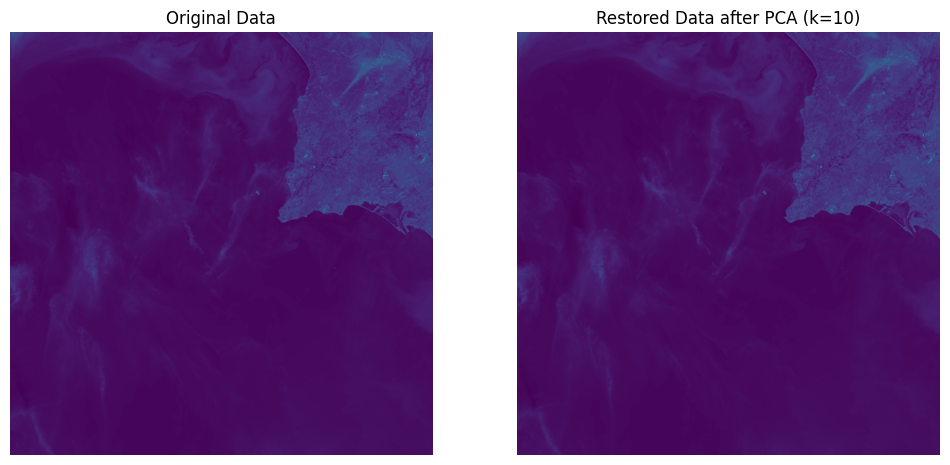

In [35]:
# Project the data onto the selected eigenvectors
reduced_data = np.dot(centered_data, selected_eigenvectors)

# Restore the data by multiplying with the selected eigenvectors and adding the mean
restored_data = np.dot(reduced_data, selected_eigenvectors.T) + mean_values

# Reshape the restored data to the original shape
restored_data = restored_data.reshape(stacked_data.shape)

# Visualize the original and restored data with equal spacing
plt.figure(figsize=(12, 6))

# Original Data
plt.subplot(1, 2, 1)
plt.imshow(stacked_data[:, :, 0], aspect='equal')
plt.title('Original Data')
plt.axis('off')

# Restored Data
plt.subplot(1, 2, 2)
plt.imshow(restored_data[:, :, 0],  aspect='equal')
plt.title(f'Restored Data after PCA (k={k})')
plt.axis('off')

Error Analysis 

value of k is a good compromise between model complexity and accuracy.


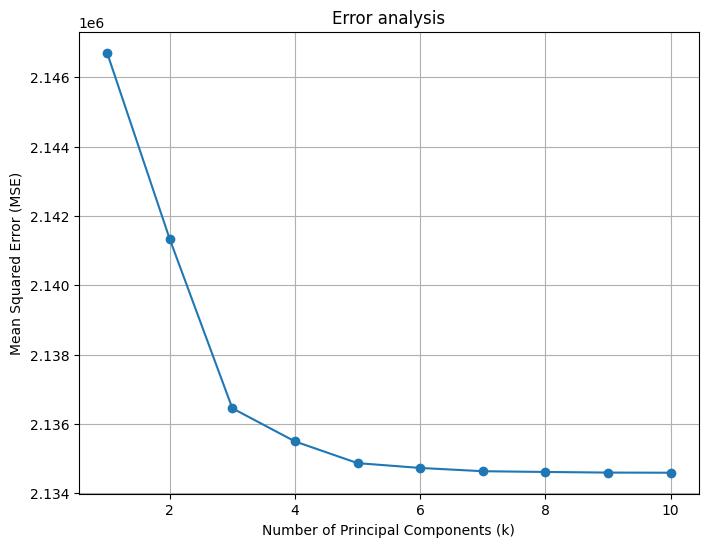

Optimal number of Principal Components (k): 10


In [39]:


# Function to reconstruct data from reduced dimensions
def reconstruct_data(reduced_data, selected_eigenvectors):
    return np.dot(reduced_data, selected_eigenvectors.T)

# Perform PCA and calculate MSE for different values of k
max_k = min(stacked_data.shape[-1], 10)  # Adjust the maximum value of k as needed
mse_values = []

for k in range(1, max_k + 1):
    # Choose the top k eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :k]

    # Project the data onto the selected eigenvectors
    reduced_data = np.dot(centered_data, selected_eigenvectors)

    # Reconstruct the data
    reconstructed_data = reconstruct_data(reduced_data, selected_eigenvectors)

    try:
        # Calculate MSE and store the result
        mse = mean_squared_error(flattened_data, reconstructed_data)
        mse_values.append(mse)
    except ValueError as e:
        print(f"Error for k={k}: {e}")

# Visualize the MSE values for different values of k
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), mse_values, marker='o')
plt.title('Error analysis')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

# Find the optimal value of k based on the MSE
optimal_k = np.argmin(mse_values) + 1
print(f"Optimal number of Principal Components (k): {optimal_k}")